In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pickle,bz2
import pandas as pd
import extinction
import corner

from scipy.io import readsav
from scipy.stats import norm
from sim_utils.GeneralRandom import GeneralRandom
from sim_utils.getmags import get_absolute_mags,get_observable_mags,get_noisy_mags
from sim_utils.oneCMD import oneCMD
from analysis.PPP_loglik import loglik,GKDE_lik,set_GR,logpost,logpost_nb


%matplotlib notebook

In [2]:
root = '/user/gennaro/ABC_synth/WORK/hercules/'

with bz2.BZ2File(root+'catalog.pbz2', 'rb') as f:
    catd = pickle.load(f)

dat_mag1 = catd['dat_mag1']
dat_mag2 = catd['dat_mag2']
dat_det  = catd['dat_det']

with bz2.BZ2File(root+'iso_int.pbz2', 'rb') as f:
    iso_int = pickle.load(f)

with bz2.BZ2File(root+'ASKDtree.pbz2', 'rb') as f:
    ASKDtree = pickle.load(f)

with bz2.BZ2File(root+'AScat.pbz2', 'rb') as f:
    AScat = pickle.load(f)

AS_mag1_in  = AScat['AS_mag1_in']
AS_mag2_in  = AScat['AS_mag2_in']
AS_mag1_out = AScat['AS_mag1_out']
AS_mag2_out = AScat['AS_mag2_out']
AS_det      = AScat['AS_det']



In [3]:
DM = 20.64
Av = 0.279

ext1 = Av*(extinction.ccm89(np.array([5921.1]),1,3.1))[0]
ext2 = Av*(extinction.ccm89(np.array([8057.0]),1,3.1))[0]

isoPD = pickle.load(open( '/user/gennaro/UFDs_OPT/shelves/isoACS.pickle', "rb" ) )
age_vals = isoPD['age_vals']
feh_vals = isoPD['feh_vals']
del(isoPD)


In [4]:
AS_det_b = AS_det
AS_det = AS_det & (AS_mag1_out < 28.5)

In [9]:
# Setup the random numbers generators

limits_all = [(np.log(0.4),np.log(5)),
              (np.amin(age_vals),np.amax(age_vals)),
              (np.amin(feh_vals),np.amax(feh_vals)),
              (20.64-1,20.64+1),
              (-1,1.),
              (0,1.),
              (0,1.)]

# ln Mass (palpha is the linear alpha, i.e. alpha salpeter = -2.3)
palpha = -1.5
pml = np.linspace(limits_all[0][0],limits_all[0][1],200)
pmv = np.exp(pml*(palpha+1))
mss_GR = GeneralRandom(pml,pmv,1000)

#Age
sfh = pd.read_table('/user/gennaro/UFDs_OPT/herc/hercsfh.txt',header=None,sep='\s+',
                   names=['age','feh','weights'])
ages_sfh = np.unique(sfh.age.values)
marg_wgt = np.zeros_like(ages_sfh)
for i,aaa in enumerate(ages_sfh):
    marg_wgt[i] = np.sum(sfh[sfh.age == aaa].weights.values)
    
pal = np.linspace(limits_all[1][0],limits_all[1][1],250)
pav = np.zeros_like(pal)
for i,aaa in enumerate(ages_sfh):
    pav = pav + marg_wgt[i]*norm.pdf(pal,loc=aaa,scale=0.1)
age_GR = GeneralRandom(pal,pav,1000)
    
#Metallicity
dicMDF = readsav('/user/gennaro/UFDs_OPT/MDFS/Summary_grid0p2_herc_adp.sav')
pfl = feh_vals
pfv = dicMDF.mednmdf
feh_GR = GeneralRandom(pfl,pfv,1000)

#DM
DMT_GR = DM

#Binary q
pbl = np.array([-1,-1e-6,0.,1])
pbv = np.array([75,75,25,25])
bin_GR = GeneralRandom(pbl,pbv,1000)

#A_606 - A_814
ex1_GR = ext1

#A_814
ex2_GR = ext2

mss, bin_GR = set_GR(-1.5,0.)


GRdic = {'logM':mss_GR,
         'Age':age_GR,
         'FeH':feh_GR,
         'DM':DM,
         'BinQ':bin_GR,
         'Alam1':ex1_GR,
         'Alam2':ex2_GR
        }

In [10]:
pars, absmags, obsmags, noisymags, ntrue, indGR = oneCMD(
    1000,GRdic,iso_int,ASKDtree,AS_mag1_in,AS_mag2_in,AS_mag1_out,AS_mag2_out,AS_det,verbose=True)

Done  0.0  % of stars
Done  10.0  % of stars
Done  20.0  % of stars
Done  30.0  % of stars
Done  40.0  % of stars
Done  50.0  % of stars
Done  60.0  % of stars
Done  70.0  % of stars
Done  80.0  % of stars
Done  90.0  % of stars
Elapsed_time (min) 0.015018533333333414
Elapsed_time  per star (millisec) 0.9011120000000049


<IPython.core.display.Javascript object>


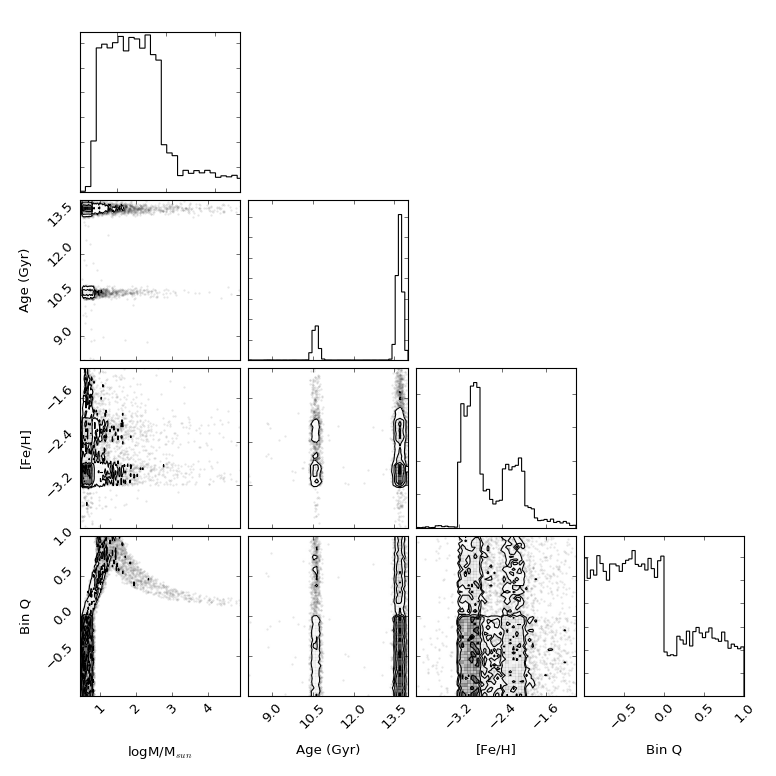

In [25]:
cols = np.array([r'logM/M$_{sun}$', 'Age (Gyr)', '[Fe/H]', 'DM', 'Bin Q', r'A$_{606}', r'A$_{814}$'])
bins = np.array([50,50,50,50,50,50,50])

plt.close("all")
dfres = pd.DataFrame(pars[:,indGR],columns=cols[indGR])
fig = corner.corner(dfres,bins=bins[indGR])


<IPython.core.display.Javascript object>


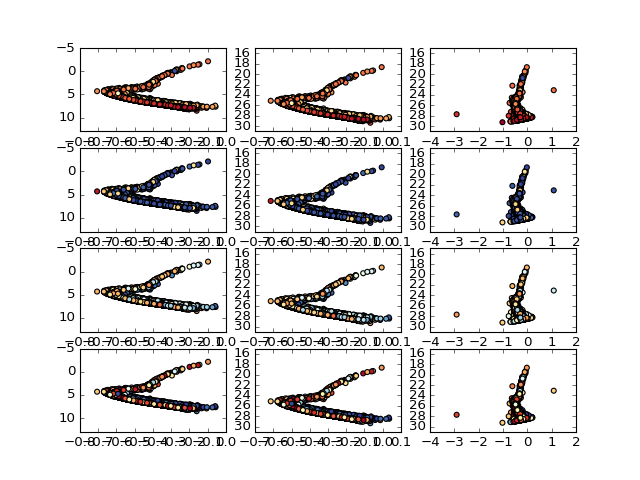

In [20]:
plt.close("all")
idone = len(indGR)

for j,iGR in enumerate(indGR):
    plt.subplot(idone,3,j*3+1)
    plt.scatter(absmags[:,0]-absmags[:,1],absmags[:,1],c=pars[:,iGR],cmap='RdYlBu')
    plt.ylim(13,-5)
    plt.subplot(idone,3,j*3+2)
    plt.scatter(obsmags[:,0]-obsmags[:,1],obsmags[:,1],c=pars[:,iGR],cmap='RdYlBu')
    plt.ylim(31,15)
    plt.subplot(idone,3,j*3+3)
    plt.scatter(noisymags[:,0]-noisymags[:,1],noisymags[:,1],c=pars[:,iGR],cmap='RdYlBu')
    plt.ylim(31,15)
    
    
